In [4]:
from pathlib import Path
from typing import cast

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
import ml_project.data as d
import ml_project.helpers as h

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
df = pd.read_csv("../data/filtered.csv")

# In case of dt, flags do not carry additional information

display(((df.mean_fiat == 0) == df.no_fiat).all())
df = df.drop(columns="no_fiat")

display(((df.mean_biat == 0) == df.no_biat).all())
df = df.drop(columns="no_biat")

display(((df.mean_idle == 0) == df.no_idle).all())
df = df.drop(columns="no_idle")

np.True_

np.True_

np.True_

In [ ]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None]
}

In [ ]:
from skopt import BayesSearchCV

# Define the search space
search_spaces = [
    {
        # "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best"],
        "max_depth": [22],
        # "min_samples_split": (2, 40),
        # "min_samples_leaf": (1, 40),
        # "max_features": [None, "log2", "sqrt"],
    },
    
]

# Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=clf,
    search_spaces=search_spaces,
    n_iter=11,
    scoring="accuracy",
    cv=4,
    n_jobs=-1,
)

bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_
import pickle
with open("dt.pkl", "wb") as f:
    pickle.dump(best_model, f)

best_model

In [9]:
X = df.drop('cls', axis=1)
y = df['cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_train, y_train, cv=4)
    print(scores)
    print(scores.mean(), scores.std())

    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"{test_accuracy=}")
    print(classification_report(y_test, y_pred))
    
    y_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred)

    print(f"{train_accuracy=}")
    return model

In [ ]:
# Barebone model
model = train(DecisionTreeClassifier(), X_train, y_train, X_test, y_test) 

[0.81908221 0.81214922 0.82898646 0.82898646]
0.8223010894684715 0.007120569748043099
test_accuracy=0.8415841584158416
              precision    recall  f1-score   support

           1       0.89      0.87      0.88       910
           2       0.71      0.72      0.72       334
           3       0.82      0.76      0.79       121
           4       0.77      0.76      0.76       292
           5       0.88      0.90      0.89      1068
           6       0.75      0.84      0.79       100
           7       0.79      0.82      0.80       205

    accuracy                           0.84      3030
   macro avg       0.80      0.81      0.80      3030
weighted avg       0.84      0.84      0.84      3030

train_accuracy=1.0


In [ ]:
# Params found through BayesSearchCV
model = train(DecisionTreeClassifier(
    criterion="entropy",
    max_depth=20,
    # min_weight_fraction_leaf=0.001,
), X_train, y_train, X_test, y_test) 

[0.82733575 0.81611093 0.82469462 0.82733575]
0.8238692637834268 0.004607225400116482
test_accuracy=0.8567656765676568
              precision    recall  f1-score   support

           1       0.90      0.89      0.90       910
           2       0.73      0.74      0.73       334
           3       0.88      0.78      0.82       121
           4       0.74      0.74      0.74       292
           5       0.90      0.91      0.90      1068
           6       0.79      0.84      0.81       100
           7       0.84      0.84      0.84       205

    accuracy                           0.86      3030
   macro avg       0.82      0.82      0.82      3030
weighted avg       0.86      0.86      0.86      3030

train_accuracy=0.9976064707824365


In [13]:
# Minimal tree

X = df.drop("cls", axis=1)

# For readability

# times = (
#     ["duration"]
#     + h.stats("fiat")
#     + h.stats("biat")
#     + h.stats("flowiat")
#     + h.stats("active")
#     + h.stats("idle")
# )

# X[times] = X[times] / h.s(1)

y = df["cls"].copy()
vpn = y > 7
y.loc[vpn] = y - 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



min = DecisionTreeClassifier(
    # criterion="entropy",
    max_depth=4,
    class_weight="balanced",
    min_weight_fraction_leaf=0.005,
)
min.fit(X_train, y_train)

# Predictions
y_pred = min.predict(X_test)

print(classification_report(y_test, y_pred))
ds = d.Dataset(Path("../data/15s.arff"))

              precision    recall  f1-score   support

           1       0.69      0.54      0.61       910
           2       0.35      0.69      0.46       334
           3       0.62      0.74      0.67       121
           4       0.23      0.59      0.33       292
           5       0.97      0.39      0.56      1068
           6       0.36      0.63      0.46       100
           7       0.56      0.37      0.44       205

    accuracy                           0.51      3030
   macro avg       0.54      0.57      0.50      3030
weighted avg       0.68      0.51      0.53      3030



|--- bps <= 77362.79
|   |--- max_flowiat <= 118390.50
|   |   |--- std_biat <= 2090.88
|   |   |   |--- std_biat <= 675.64
|   |   |   |   |--- class: FT
|   |   |   |--- std_biat >  675.64
|   |   |   |   |--- class: BROWSING
|   |   |--- std_biat >  2090.88
|   |   |   |--- bps <= 14435.19
|   |   |   |   |--- class: VOIP
|   |   |   |--- bps >  14435.19
|   |   |   |   |--- class: BROWSING
|   |--- max_flowiat >  118390.50
|   |   |--- min_fiat <= 440783.50
|   |   |   |--- std_idle <= 29388.77
|   |   |   |   |--- class: MAIL
|   |   |   |--- std_idle >  29388.77
|   |   |   |   |--- class: CHAT
|   |   |--- min_fiat >  440783.50
|   |   |   |--- mean_active <= 10036727.00
|   |   |   |   |--- class: P2P
|   |   |   |--- mean_active >  10036727.00
|   |   |   |   |--- class: BROWSING
|--- bps >  77362.79
|   |--- mean_fiat <= 1035.91
|   |   |--- min_biat <= 10.50
|   |   |   |--- mean_biat <= 113.22
|   |   |   |   |--- class: FT
|   |   |   |--- mean_biat >  113.22
|   |   |   |

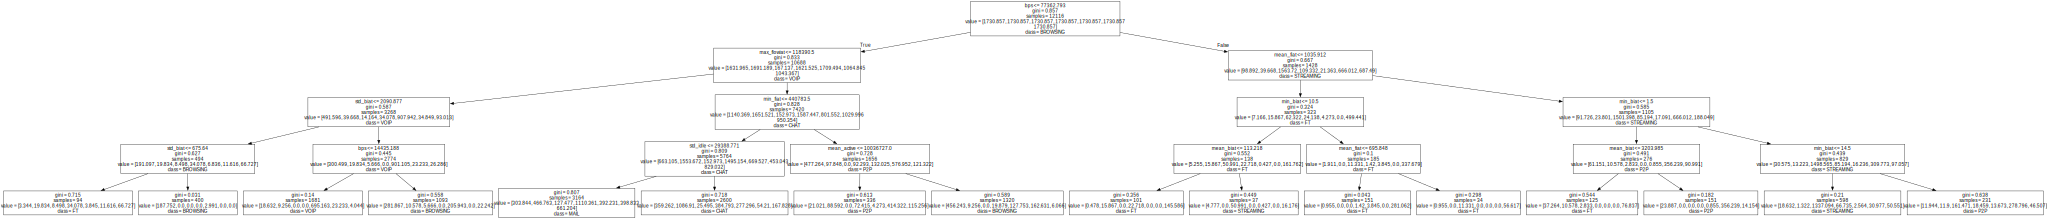

In [ ]:
# Goal: visualise the decision tree
from sklearn import tree

classes=list(map(bytes.decode, ds.cls_list))[:7]
print(
    tree.export_text(
        min,
        feature_names=X.columns,
        class_names=classes,
    )
)

from graphviz import Source
from sklearn import tree
graph = Source( tree.export_graphviz(min, out_file=None, feature_names=X.columns, class_names=classes))
from IPython.display import SVG
SVG(graph.pipe(format='svg'))